# Texturize Images

This notebook documents how we convert the test images to equivalent image textures. The idea behind texturizing images comes from [Gatys et al.](https://arxiv.org/abs/1505.07376). This notebook is built largely off their implementation, found [here](https://github.com/leongatys/DeepTextures/blob/master/Example.ipynb)

In [1]:
%matplotlib inline
from collections import OrderedDict
import glob
import os
import sys

import caffe
import imageio
import numpy as np
import tqdm

sys.path.append('../code/DeepImageSynthesis')
from DeepImageSynthesis import * 

im_dir = os.path.join('../data/test')
gpu = 0
caffe.set_mode_gpu() #for cpu mode do 'caffe.set_mode_cpu()'
caffe.set_device(gpu)

caffe.set_random_seed(42)
np.random.seed(42)

In [2]:
def texturize_image(img_path):
    '''Take in an image path, and convert the image to a texturized form'''
    # Set the number of iterations 
    maxiter = 1000
    m = 20
    
    # Set model details
    VGGweights = os.path.join('../gatys_files/vgg_normalised.caffemodel')
    VGGmodel = os.path.join('../gatys_files/VGG_ave_pool_deploy.prototxt')
    imagenet_mean = np.array([ 0.40760392,  0.45795686,  0.48501961]) #mean for color channels (bgr)
    
    # Preload the image to get the image length for the network
    source_image = caffe.io.load_image(img_path)
    im_size = float(source_image.shape[1])
    
    # Initialize the network
    [source_img, net] = load_image(img_path, im_size, 
                            VGGmodel, VGGweights, imagenet_mean, 
                            show_img=True)
    im_size = np.asarray(source_img.shape[-2:]) 

    #define layers to include in the texture model and weights w_l
    tex_layers = ['pool4', 'pool3', 'pool2', 'pool1', 'conv1_1']
    tex_weights = [1e9,1e9,1e9,1e9,1e9]

    #pass image through the network and save the constraints on each layer
    constraints = OrderedDict()
    net.forward(data = source_img)
    for l,layer in enumerate(tex_layers):
        constraints[layer] = constraint([LossFunctions.gram_mse_loss],
                                        [{'target_gram_matrix': gram_matrix(net.blobs[layer].data),
                                         'weight': tex_weights[l]}])

    #get optimisation bounds
    bounds = get_bounds([source_img],im_size)

    #generate new texture
    result = ImageSyn(net, constraints, bounds=bounds,
                      minimize_options={'maxiter': maxiter,
                                        'maxcor': m,
                                        'ftol': 0, 'gtol': 0,
                                       })
    
    return result

In [3]:
def unflatten_image(img, img_length):
    '''The output of the texturization process is a flattened image because neural networks. This function
    reconstitutes the image by [0, 1] rescaling it and reshaping it to a (img_length, img_length, 3) image'''
    centered_image = (img - img.min()) / (img.max() - img.min())

    # Unflatten the result
    result_image = centered_image.reshape(3, img_length, img_length)

    # Convert image to (rows, cols, channels) from (channels, rows, cols)
    result_image = result_image.transpose(1,2,0)

    # Flip the channels (they were backwards for some reason)
    result_image = result_image[:,:,::-1]
    
    return result_image

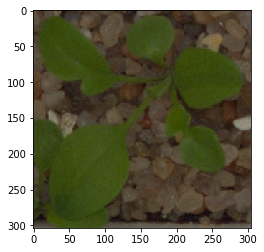

In [4]:
%%capture --no-display
base_dir = '../data/test'
out_dir = '../data/texturized'

for file in tqdm.tqdm_notebook(os.listdir(base_dir)):
    file_path = os.path.join(base_dir, file)
    
    if os.path.exists(os.path.join(out_dir, file)):
        print('Skipping {}'.format(file))
        continue
    
    if '.png' in file:
        img = imageio.imread(file_path)
        img_length = img.shape[1]
        flattened_texturized_img = texturize_image(file_path)['x']
        
        texturized_img = unflatten_image(flattened_texturized_img, img_length)
        
        imageio.imsave(os.path.join(out_dir, file), texturized_img)

In [5]:
%%capture
# Texturize a single image as an example
# This function is just like texturize_image, but has a callback to save the intermediate images

VGGweights = os.path.join('../gatys_files/vgg_normalised.caffemodel')
VGGmodel = os.path.join('../gatys_files/VGG_ave_pool_deploy.prototxt')
imagenet_mean = np.array([0.40760392,  0.45795686,  0.48501961]) #mean for color channels (bgr)

#load source image
source_img_name = os.path.join(im_dir, '1bf9b94a6.png')
source_img_org = caffe.io.load_image(source_img_name)

im_size = float(source_img_org.shape[1])
[source_img, net] = load_image(source_img_name, im_size, 
                            VGGmodel, VGGweights, imagenet_mean, 
                            show_img=True)
im_size = np.asarray(source_img.shape[-2:])

maxiter = 1000
m = 20

#define layers to include in the texture model and weights w_l
tex_layers = ['pool4', 'pool3', 'pool2', 'pool1', 'conv1_1']
tex_weights = [1e9,1e9,1e9,1e9,1e9]

#pass image through the network and save the constraints on each layer
constraints = OrderedDict()
net.forward(data = source_img)
for l,layer in enumerate(tex_layers):
    constraints[layer] = constraint([LossFunctions.gram_mse_loss],
                                    [{'target_gram_matrix': gram_matrix(net.blobs[layer].data),
                                     'weight': tex_weights[l]}])
    
#get optimisation bounds
bounds = get_bounds([source_img], im_size)


def store_images(x, net, writer):
    '''This function is used as a callback in ImageSyn, and stores images in a file'''
    # This line is lifted from DeepImageSynthesis/Misc.py
    disp_image = (x.reshape(*net.blobs['data'].data.shape)[0].transpose(1,2,0)[:,:,::-1]-x.min())/(x.max()-x.min())
    writer.append_data(disp_image)

result = None
with imageio.get_writer('../results/texturizing_plant.gif', mode='I') as writer: 
    #generate new texture
    result = ImageSyn(net, constraints, bounds=bounds,
                      callback=lambda x: store_images(x,net, writer), 
                      minimize_options={'maxiter': maxiter,
                                        'maxcor': m,
                                        'ftol': 0, 'gtol': 0,
                                       })

plt.imshow(unflatten_image(result, im_size))

AttributeError: min